# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [59]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
df=pd.read_csv('/kaggle/input/crop-recommendation/Crop_recommendation.csv')
df.drop(columns=['Unnamed: 8','Unnamed: 9'],inplace=True)
df.head()

,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [22]:
corr=df.drop(columns=['label']).corr()
corr.style.background_gradient(cmap='coolwarm')

,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall
Nitrogen,1.000000,-0.231460,-0.140512,0.026504,0.190688,0.096683,0.059020
phosphorus,-0.231460,1.000000,0.736232,-0.127541,-0.118734,-0.138019,-0.063839
potassium,-0.140512,0.736232,1.000000,-0.160387,0.190859,-0.169503,-0.053461
temperature,0.026504,-0.127541,-0.160387,1.000000,0.205320,-0.017795,-0.030084
humidity,0.190688,-0.118734,0.190859,0.205320,1.000000,-0.008483,0.094423
ph,0.096683,-0.138019,-0.169503,-0.017795,-0.008483,1.000000,-0.109069
rainfall,0.059020,-0.063839,-0.053461,-0.030084,0.094423,-0.109069,1.000000


In [27]:
df.columns[:-1]

Index(['Nitrogen', 'phosphorus', 'potassium', 'temperature', 'humidity', 'ph',
       'rainfall'],
      dtype='object')

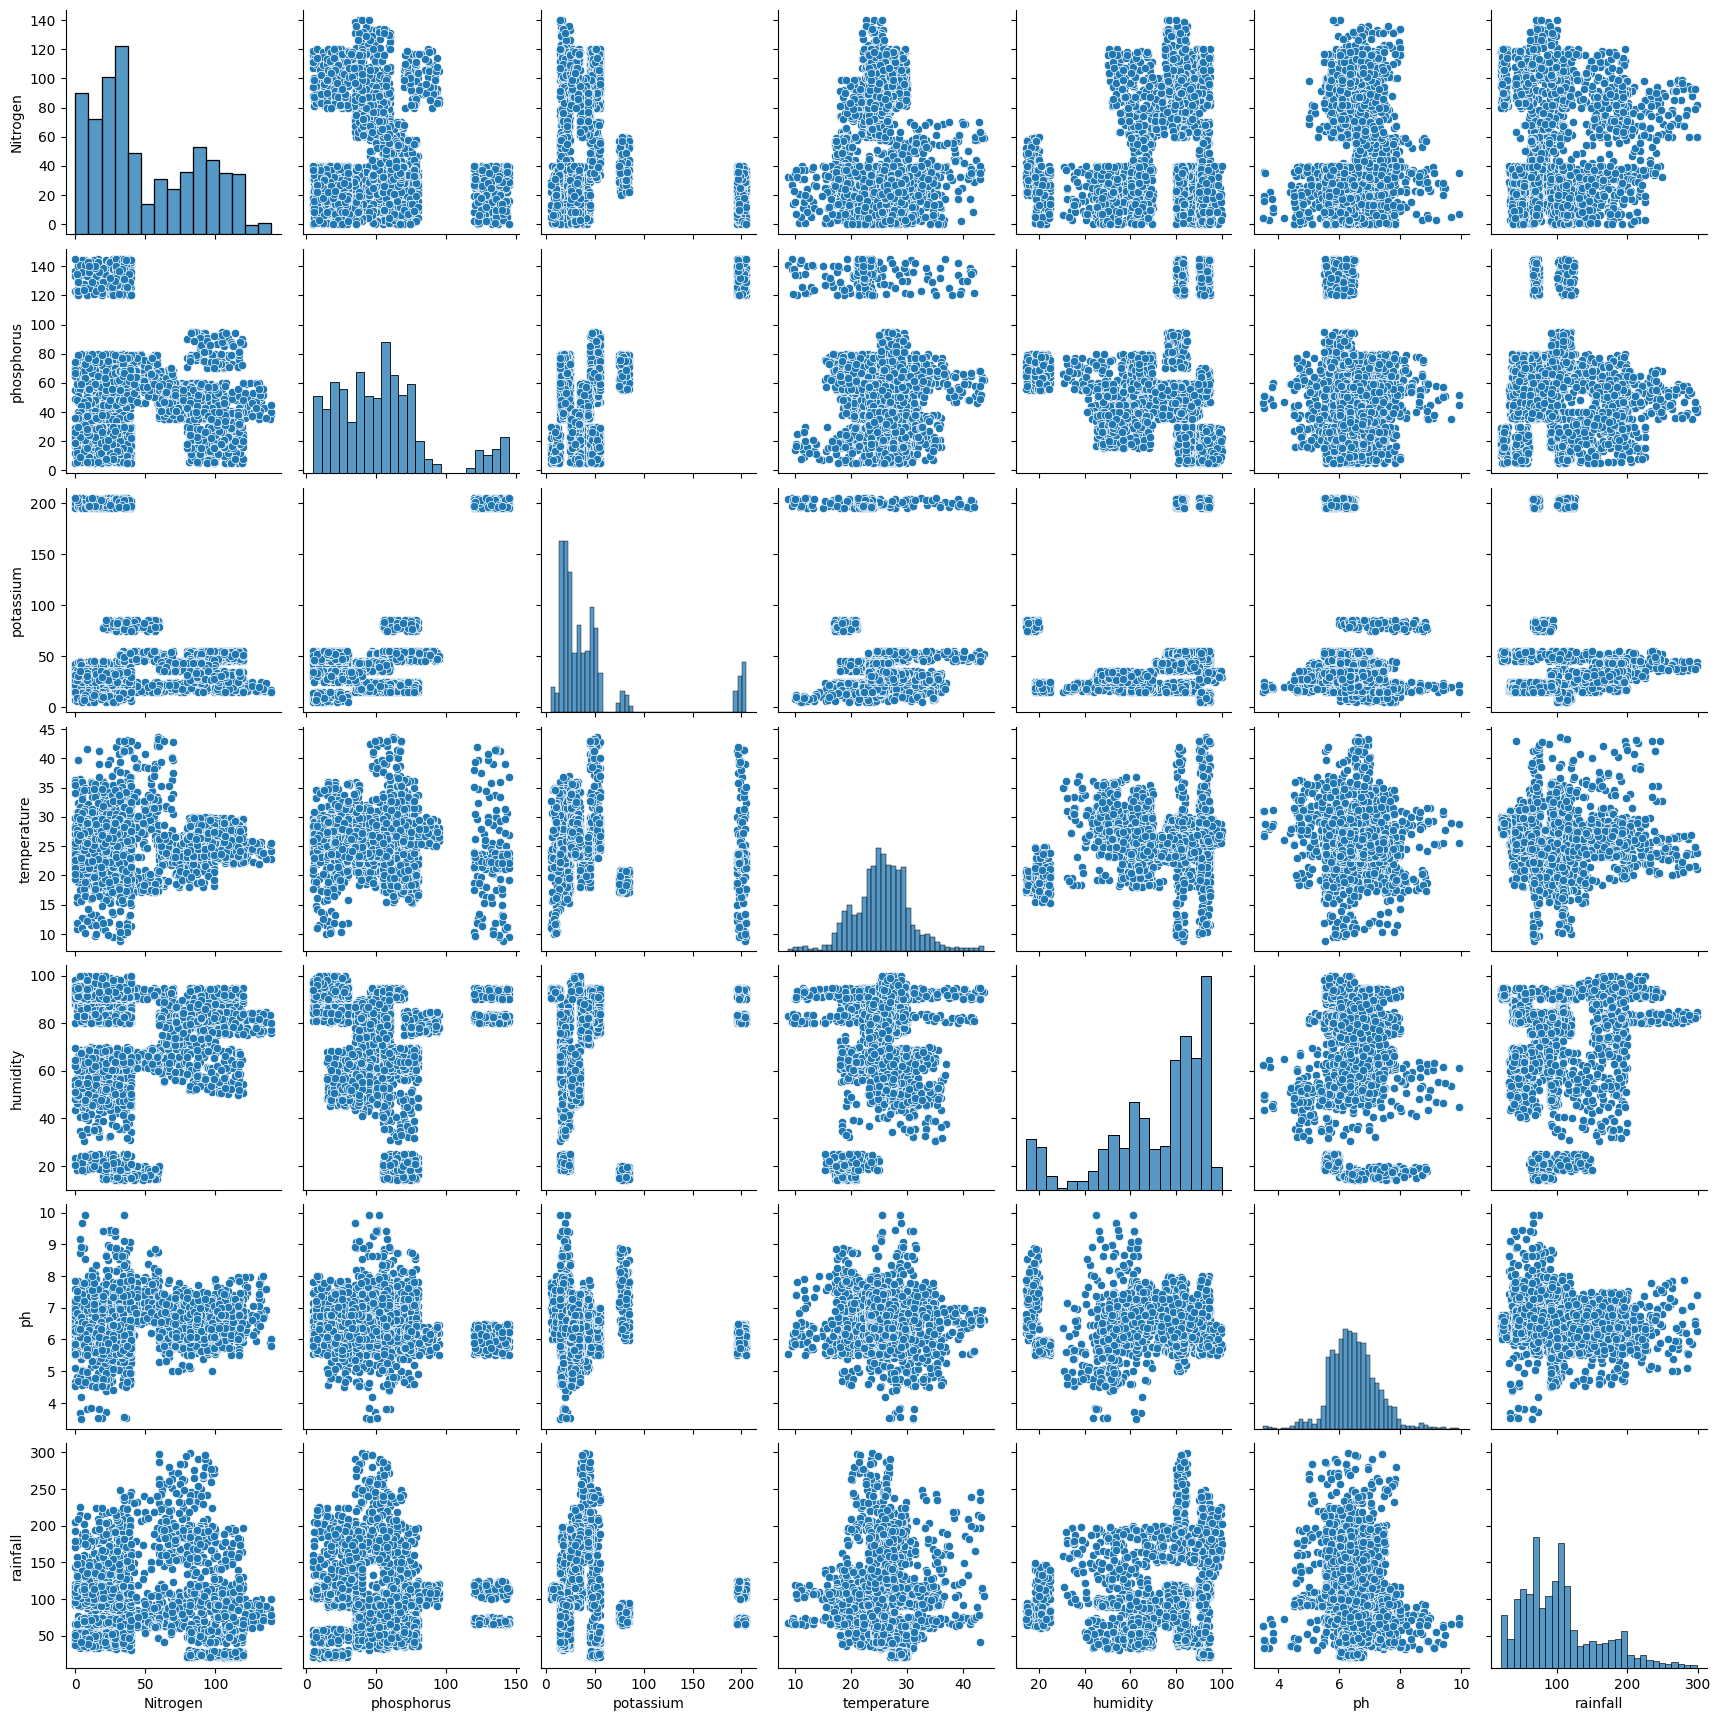

In [32]:
numeric_cats=df.columns[:-1]
sns.pairplot(df[numeric_cats],)
plt.show()

In [30]:
df.isnull().sum()

Nitrogen       0
phosphorus     0
potassium      0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [57]:
df.label.value_counts()

label
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64

In [50]:
crop_labels

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [56]:
crop_labels=df.label.unique()
arr_for_anova=[]
for crop in crop_labels:
    arr_for_anova.append(df[df.label==crop][numeric_cats].values)
f_val,p_val=stats.f_oneway(arr_for_anova[0],arr_for_anova[1],arr_for_anova[2],arr_for_anova[3],
                           arr_for_anova[4],arr_for_anova[5],arr_for_anova[6],arr_for_anova[7],
                           arr_for_anova[8],arr_for_anova[9],arr_for_anova[10],arr_for_anova[11],
                           arr_for_anova[12],arr_for_anova[13],arr_for_anova[14],arr_for_anova[15],
                           arr_for_anova[16],arr_for_anova[17],arr_for_anova[18],arr_for_anova[19],
                           arr_for_anova[20],arr_for_anova[21])
print(f"F-statistic: {f_val}")
print(f"P-value: {p_val}")

F-statistic: [  897.56818633  1885.65785918 27238.36206707   102.18698123
  3103.70889122    60.34403353   605.52796614]
P-value: [0.00000000e+000 0.00000000e+000 0.00000000e+000 4.01932382e-305
 0.00000000e+000 6.49316190e-199 0.00000000e+000]


In [85]:
average_stats=df.groupby('label').mean().reset_index()
average_stats

,label,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall
0,apple,20.80,134.22,199.89,22.630942,92.333383,5.929663,112.654779
1,banana,100.23,82.01,50.05,27.376798,80.358123,5.983893,104.626980
2,blackgram,40.02,67.47,19.24,29.973340,65.118426,7.133952,67.884151
3,chickpea,40.09,67.79,79.92,18.872847,16.860439,7.336957,80.058977
4,coconut,21.98,16.93,30.59,27.409892,94.844272,5.976562,175.686646
5,coffee,101.20,28.74,29.94,25.540477,58.869846,6.790308,158.066295
6,cotton,117.77,46.24,19.56,23.988958,79.843474,6.912675,80.398043
7,grapes,23.18,132.53,200.11,23.849575,81.875228,6.025937,69.611829
8,jute,78.40,46.86,39.99,24.958376,79.639864,6.732778,174.792798
9,kidneybeans,20.75,67.54,20.05,20.115085,21.605357,5.749411,105.919778


In [120]:
crop_types=average_stats.index.values
chart1=alt.Chart(average_stats).mark_bar().encode(
    
    x=alt.X('temperature',title='avg temperature'),
    y=alt.Y('label',title='crops'),
    color=alt.Color("label",legend=None)
).properties(title='Temperature')
chart1+chart1.mark_text(dx=1,align='left')

chart2=alt.Chart(average_stats).mark_bar().encode(
    
    x=alt.X('rainfall',title='avg rainfall'),
    y=alt.Y('label',title='crops'),
    color=alt.Color("label",legend=None)
).properties(title='Rainfall')
chart2+chart2.mark_text(dx=1,align='left')

concat_chart=alt.hconcat(chart1,chart2,title='Average crops temperature and rainfall')
concat_chart.show()

alt.HConcatChart(...)

In [122]:
crop_types=average_stats.index.values
chart1=alt.Chart(average_stats).mark_bar().encode(
    
    x=alt.X('humidity',title='avg humidity'),
    y=alt.Y('label',title='crops'),
    color=alt.Color("label",legend=None)
).properties(title='Humidity')

chart2=alt.Chart(average_stats).mark_bar().encode(
    
    x=alt.X('ph',title='avg ph'),
    y=alt.Y('label',title='crops'),
    color=alt.Color("label",legend=None)
).properties(title='Ph value')

concat_chart=alt.hconcat(chart1,chart2,title='Average crops Humidity and Ph value')
concat_chart.show()

alt.HConcatChart(...)

In [133]:
numeric_cats

Index(['Nitrogen', 'phosphorus', 'potassium', 'temperature', 'humidity', 'ph',
       'rainfall'],
      dtype='object')

In [205]:
data=df.copy()
label_encoder=LabelEncoder()
data['label']=label_encoder.fit_transform(data['label'])
min_max_scaler=MinMaxScaler()
data[numeric_cats]=min_max_scaler.fit_transform(data[numeric_cats])

In [211]:
import joblib
joblib.dump(label_encoder, 'label_encoder.jbl')
joblib.dump(min_max_scaler, 'min_max_scaler.jbl')

['min_max_scaler.jbl']

In [225]:
df.describe()

,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [154]:
X=data[numeric_cats].values
y=data['label']
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=23)
train_X.shape,test_X.shape,train_y.shape,test_y.shape

((1760, 7), (440, 7), (1760,), (440,))

In [156]:
test_y

1158    12
791      2
1567     0
1663    16
952     19
        ..
1973     6
1692    16
904     19
264      3
1686    16
Name: label, Length: 440, dtype: int64

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        23
           3       1.00      0.96      0.98        23
           4       1.00      0.95      0.98        22
           5       1.00      0.90      0.95        21
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        17
           8       0.84      0.94      0.89        17
           9       0.95      1.00      0.98        20
          10       1.00      1.00      1.00        17
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        23
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        20
          17       1.00    

Text(0.5, 1.0, 'Confusion matrix of XGBoost')

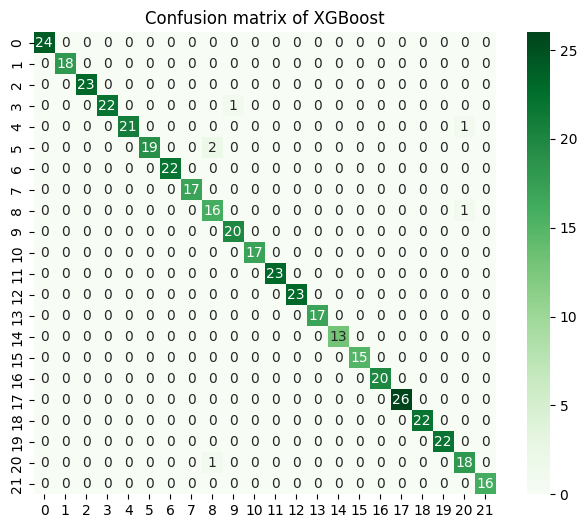

In [196]:
xgb_model=XGBClassifier()
xgb_model.fit(train_X,train_y)
pred=xgb_model.predict(test_X)
#accuracy_score(test_y,pred)
print(classification_report(test_y,pred))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(test_y,pred),cmap='Greens',
            linecolor='black',annot=True,square=True)
plt.title('Confusion matrix of XGBoost')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        18
           2       0.96      1.00      0.98        23
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        17
           8       0.94      0.94      0.94        17
           9       1.00      1.00      1.00        20
          10       1.00      0.94      0.97        17
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        23
          13       0.94      0.94      0.94        17
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        20
          17       1.00    

Text(0.5, 1.0, 'Confusion matrix of DecisionTree')

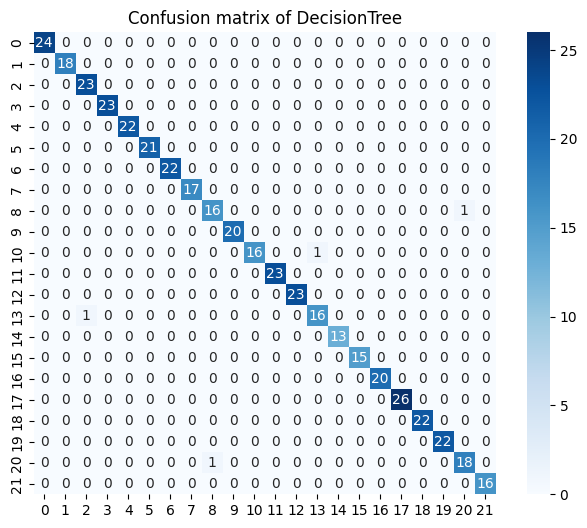

In [198]:
ds_model=DecisionTreeClassifier()
ds_model.fit(train_X,train_y)
pred=ds_model.predict(test_X)
#accuracy_score(test_y,pred)
print(classification_report(test_y,pred))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(test_y,pred),cmap='Blues',
            linecolor='black',annot=True,square=True)
plt.title('Confusion matrix of DecisionTree')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        17
           8       0.94      1.00      0.97        17
           9       1.00      1.00      1.00        20
          10       1.00      1.00      1.00        17
          11       1.00      1.00      1.00        23
          12       1.00      1.00      1.00        23
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        20
          17       1.00    

Text(0.5, 1.0, 'Confusion matrix of RandomForest')

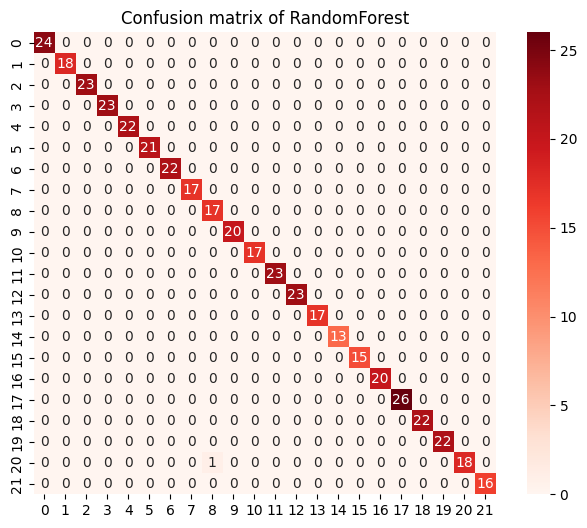

In [199]:
rf_model=RandomForestClassifier()
rf_model.fit(train_X,train_y)
pred=rf_model.predict(test_X)
#accuracy_score(test_y,pred)
print(classification_report(test_y,pred))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(test_y,pred),cmap='Reds',
            linecolor='black',annot=True,square=True)
plt.title('Confusion matrix of RandomForest')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        18
           2       0.88      0.91      0.89        23
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        21
           6       0.92      1.00      0.96        22
           7       1.00      1.00      1.00        17
           8       0.93      0.82      0.87        17
           9       0.91      1.00      0.95        20
          10       0.89      0.94      0.91        17
          11       1.00      0.91      0.95        23
          12       0.96      1.00      0.98        23
          13       1.00      0.82      0.90        17
          14       0.81      1.00      0.90        13
          15       0.88      1.00      0.94        15
          16       1.00      0.90      0.95        20
          17       1.00    

Text(0.5, 1.0, 'Confusion matrix of Oranges')

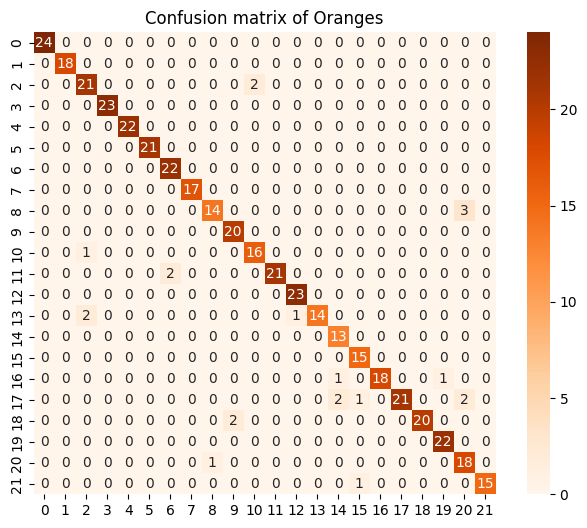

In [200]:
lr_model=LogisticRegression()
lr_model.fit(train_X,train_y)
pred=lr_model.predict(test_X)
#accuracy_score(test_y,pred)
print(classification_report(test_y,pred))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(test_y,pred),cmap='Oranges',
            linecolor='black',annot=True,square=True)
plt.title('Confusion matrix of Oranges')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        21
           6       0.92      1.00      0.96        22
           7       1.00      1.00      1.00        17
           8       0.77      1.00      0.87        17
           9       0.95      1.00      0.98        20
          10       1.00      1.00      1.00        17
          11       1.00      0.91      0.95        23
          12       1.00      1.00      1.00        23
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        20
          17       1.00    

Text(0.5, 1.0, 'Confusion matrix of Support Vector Machine')

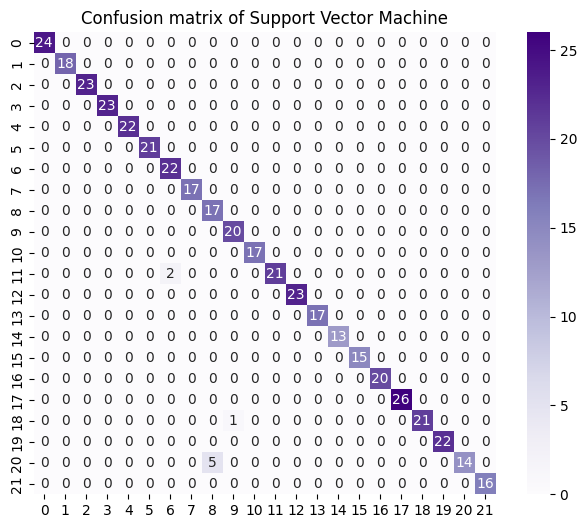

In [201]:
svm_model=SVC()
svm_model.fit(train_X,train_y)
pred=svm_model.predict(test_X)
#accuracy_score(test_y,pred)
print(classification_report(test_y,pred))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(test_y,pred),cmap='Purples',
            linecolor='black',annot=True,square=True)
plt.title('Confusion matrix of Support Vector Machine')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1329
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 7
[LightGBM] [Info] Start training from score -3.142336
[LightGBM] [Info] Start training from score -3.066350
[LightGBM] [Info] Start training from score -3.129264
[LightGBM] [Info] Start training from score -3.129264
[LightGBM] [Info] Start training from score -3.116360
[LightGBM] [Info] Start training from score -3.103621
[LightGBM] [Info] Start training from score -3.116360
[LightGBM] [Info] Start training from score -3.054228
[LightGBM] [Info] Start training from score -3.054228
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.054228
[LightGBM] [Info] Start training from score -3.129264
[LightGBM] [Info] Start training from score -3.129264
[LightGBM] 

Text(0.5, 1.0, 'Confusion matrix of XGBoost')

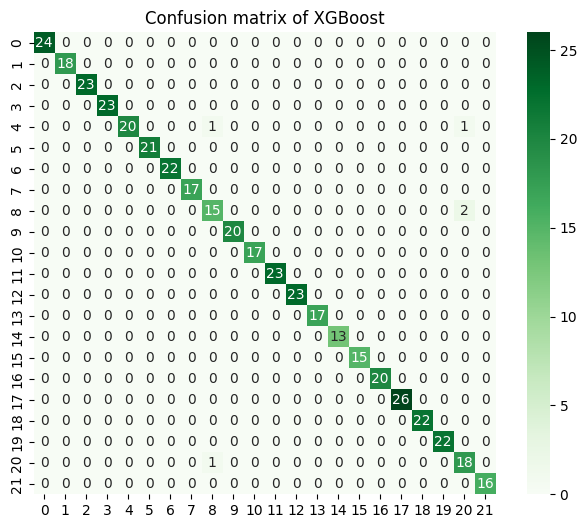

In [202]:
lgb_model=LGBMClassifier()
lgb_model.fit(train_X,train_y)
pred=lgb_model.predict(test_X)
#accuracy_score(test_y,pred)
print(classification_report(test_y,pred))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(test_y,pred),cmap='Greens',
            linecolor='black',annot=True,square=True)
plt.title('Confusion matrix of LightBGM')

In [204]:
import joblib
joblib.dump(lgb_model, 'lgb_model.h5')

['lgb_model.h5']